# Machine Learning Trading Bot

In [103]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

## Establish a Baseline Performance

In [104]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("../Desktop/csv/emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [105]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


## Step 2: Generate trading signals using short- and long-window SMA values. 

In [106]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495


In [107]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0


In [108]:
signals_df['Signal'].value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [109]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()
signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0,NaN
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0,0.000000
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0,0.000803
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0,0.000401
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0,0.001202


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0,-0.000896


<AxesSubplot:xlabel='date'>

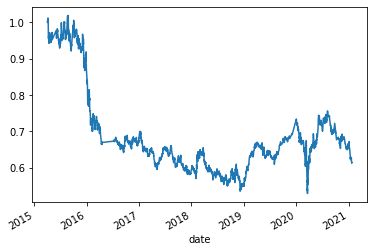

In [110]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

### Step 3: Split the data into training and testing datasets.

In [111]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [112]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [113]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-04-02 15:00:00


In [114]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2015-07-02 15:00:00


In [115]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [116]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Review the X_test DataFrame
X_test.head()

,SMA_Fast,SMA_Slow
date,,
2015-07-02 15:15:00,24.1450,25.1258
2015-07-02 15:45:00,24.1300,25.1092
2015-07-06 10:00:00,24.1250,25.0919
2015-07-06 10:45:00,23.9700,25.0682
2015-07-06 14:15:00,23.8475,25.0458


In [117]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Step 4: Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

In [118]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred[:10]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Step 5: Review the classification report associated with the `SVC` model predictions. 

In [119]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.43      0.04      0.07      1806
         1.0       0.56      0.96      0.71      2288

    accuracy                           0.55      4094
   macro avg       0.49      0.50      0.39      4094
weighted avg       0.50      0.55      0.43      4094



In [120]:
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [121]:
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.43      0.04      0.07      1806
         1.0       0.56      0.96      0.71      2288

    accuracy                           0.55      4094
   macro avg       0.49      0.50      0.39      4094
weighted avg       0.50      0.55      0.43      4094



### Step 6: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [122]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = testing_signal_predictions

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = signals_df['Strategy Returns']
# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-02 15:15:00,1.0,-0.000828,-0.000828
2015-07-02 15:45:00,1.0,-0.000829,0.000829
2015-07-06 10:00:00,1.0,-0.025715,0.025715
2015-07-06 10:45:00,1.0,0.007237,-0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,-0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


### Step 7: Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

<AxesSubplot:xlabel='date'>

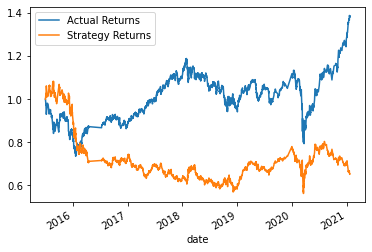

In [123]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()

## Tune the Baseline Trading Algorithm

### Step 1: Tune the training algorithm by adjusting the size of the training dataset. 

To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

In [124]:
trading_algo_df = pd.DataFrame(signals_df['2015-07-06 10:45:00' : '2021-01-22 09:30:00'])

trading_algo_df.head()

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-07-06 10:45:00,23.66,0.007237,23.8475,25.0458,1.0,-0.007237
2015-07-06 14:15:00,23.43,-0.009721,23.6725,25.0206,-1.0,-0.009721
2015-07-06 14:30:00,23.34,-0.003841,23.4800,24.9951,-1.0,0.003841
2015-07-07 11:30:00,22.91,-0.018423,23.3350,24.9625,-1.0,0.018423
2015-07-07 13:45:00,23.04,0.005674,23.1800,24.9323,1.0,-0.005674


### Step 2: Tune the trading algorithm by adjusting the SMA input features. 

Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

Answer: When increasing the training window, it is noticeable that there was only a slight increase in the strategy returns, whilst a greater increase occurred in the Actual Returns. However, as this is only a small slice of the total dataframe, it is unreasonable to assume it's overall accuracy to the original data. Although, both graphs display the same pattern in fluctuationss of the returns.

In [125]:
short_window = 8
long_window = 200

In [126]:
trading_algo_df['SMA_Fast'] = trading_algo_df['close'].rolling(window=short_window).mean()
trading_algo_df['SMA_Slow'] = trading_algo_df['close'].rolling(window=long_window).mean()

In [127]:
# Initialize the new Signal column
trading_algo_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
trading_algo_df.loc[(trading_algo_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
trading_algo_df.loc[(trading_algo_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(trading_algo_df.head())
display(trading_algo_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-07-06 10:45:00,23.66,0.007237,NaN,NaN,1.0,-0.007237
2015-07-06 14:15:00,23.43,-0.009721,NaN,NaN,-1.0,-0.009721
2015-07-06 14:30:00,23.34,-0.003841,NaN,NaN,-1.0,0.003841
2015-07-07 11:30:00,22.91,-0.018423,NaN,NaN,-1.0,0.018423
2015-07-07 13:45:00,23.04,0.005674,NaN,NaN,1.0,-0.005674


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-19 09:30:00,33.15,0.009132,32.73250,28.93865,1.0,0.009132
2021-01-19 11:15:00,33.07,-0.002413,32.78125,28.96850,-1.0,-0.002413
2021-01-19 12:30:00,32.97,-0.003024,32.81625,28.99585,-1.0,0.003024
2021-01-20 09:45:00,33.50,0.016075,32.94000,29.02550,1.0,-0.016075
2021-01-22 09:30:00,33.27,-0.006866,33.02625,29.05610,-1.0,-0.006866


In [128]:
trading_algo_df['Signal'].value_counts()

 1.0    2285
-1.0    1802
Name: Signal, dtype: int64

In [129]:
# Calculate the strategy returns and add them to the signals_df DataFrame
trading_algo_df['Strategy Returns'] = trading_algo_df['Actual Returns'] * trading_algo_df['Signal'].shift()

# Review the DataFrame
display(trading_algo_df.head())
display(trading_algo_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-07-06 10:45:00,23.66,0.007237,NaN,NaN,1.0,NaN
2015-07-06 14:15:00,23.43,-0.009721,NaN,NaN,-1.0,-0.009721
2015-07-06 14:30:00,23.34,-0.003841,NaN,NaN,-1.0,0.003841
2015-07-07 11:30:00,22.91,-0.018423,NaN,NaN,-1.0,0.018423
2015-07-07 13:45:00,23.04,0.005674,NaN,NaN,1.0,-0.005674


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-19 09:30:00,33.15,0.009132,32.73250,28.93865,1.0,0.009132
2021-01-19 11:15:00,33.07,-0.002413,32.78125,28.96850,-1.0,-0.002413
2021-01-19 12:30:00,32.97,-0.003024,32.81625,28.99585,-1.0,0.003024
2021-01-20 09:45:00,33.50,0.016075,32.94000,29.02550,1.0,-0.016075
2021-01-22 09:30:00,33.27,-0.006866,33.02625,29.05610,-1.0,-0.006866


<AxesSubplot:xlabel='date'>

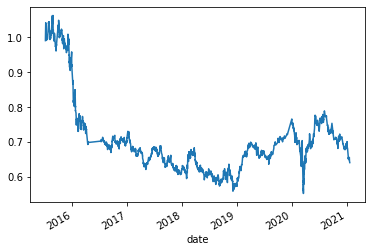

In [130]:
(1 + trading_algo_df['Strategy Returns']).cumprod().plot()

<AxesSubplot:xlabel='date'>

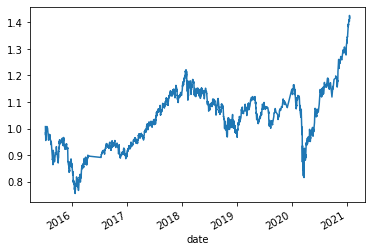

In [131]:
(1 + trading_algo_df['Actual Returns']).cumprod().plot()

<AxesSubplot:xlabel='date'>

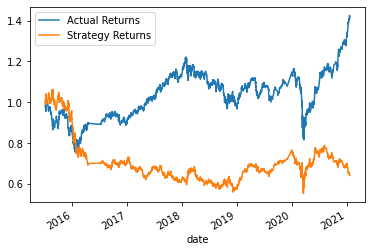

In [132]:
returns_plot = (1 + trading_algo_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()

returns_plot

### Step 3: Choose the set of parameters that best improved the trading algorithm returns. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

In [133]:
returns_plot.figure.savefig('returns_png')

---
## Evaluate a New Machine Learning Classifier

### Step 1:  Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

In [134]:
# Import a new classifier from SKLearn
from sklearn.linear_model import LogisticRegression

# Initiate the model instance
logistic_regression_model = LogisticRegression()

### Step 2: Using the original training data as the baseline model, fit another model with the new classifier.

In [135]:
# Fit the model using the training data
model = logistic_regression_model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
lr_training_signal_predictions = logistic_regression_model.predict(X_test_scaled)

# Review the model's predicted values
lr_training_signal_predictions


array([ 1.,  1.,  1., ..., -1., -1., -1.])

### Step 3: Backtest the new model to evaluate its performance. 

Did this new model perform better or worse than the provided baseline model? 

Answer:

Did this new model perform better or worse than your tuned trading algorithm?

Answer:

In [136]:
# Use a classification report to evaluate the model using the predictions and training data
training_classification_report = classification_report(y_test, lr_training_signal_predictions)

# Print the classification report
print(training_classification_report)

              precision    recall  f1-score   support

        -1.0       0.44      0.33      0.38      1806
         1.0       0.56      0.66      0.61      2288

    accuracy                           0.52      4094
   macro avg       0.50      0.50      0.49      4094
weighted avg       0.51      0.52      0.51      4094



In [137]:
classification_report_2 = model.predict(X_test_scaled)

In [138]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_classification_report = classification_report(y_test, classification_report_2)

# Print the classification report
print(testing_classification_report)

              precision    recall  f1-score   support

        -1.0       0.44      0.33      0.38      1806
         1.0       0.56      0.66      0.61      2288

    accuracy                           0.52      4094
   macro avg       0.50      0.50      0.49      4094
weighted avg       0.51      0.52      0.51      4094



In [139]:
# Create a new empty predictions DataFrame:
# Create a predictions DataFrame
predictions_df_2 = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df_2['Predicted'] = testing_classification_report

# Add the actual returns to the DataFrame
predictions_df_2['Actual Returns'] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df_2['Strategy Returns'] = signals_df['Strategy Returns']
# Review the DataFrame
display(predictions_df_2.head())
display(predictions_df_2.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-02 15:15:00,precision recall f1-score ...,-0.000828,-0.000828
2015-07-02 15:45:00,precision recall f1-score ...,-0.000829,0.000829
2015-07-06 10:00:00,precision recall f1-score ...,-0.025715,0.025715
2015-07-06 10:45:00,precision recall f1-score ...,0.007237,NaN
2015-07-06 14:15:00,precision recall f1-score ...,-0.009721,-0.009721


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,precision recall f1-score ...,-0.006866,-0.006866
2021-01-22 11:30:00,precision recall f1-score ...,0.002405,-0.002405
2021-01-22 13:45:00,precision recall f1-score ...,0.002099,0.002099
2021-01-22 14:30:00,precision recall f1-score ...,0.001496,0.001496
2021-01-22 15:45:00,precision recall f1-score ...,-0.000896,-0.000896


<AxesSubplot:xlabel='date'>

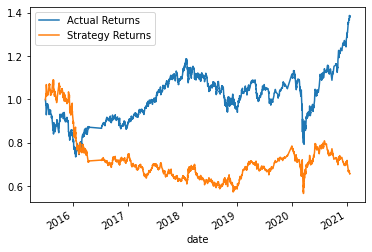

In [140]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df_2[["Actual Returns", "Strategy Returns"]]).cumprod().plot()